# Driftscan FFI analysis

Michael Gully-Santiago  
May 16, 2018

This notebook follows a tutorial from [sep](http://sep.readthedocs.io/), maintained by Kyle Barbary.

The goal of this notebook is to quantify the driftscan FFI motion.

In [1]:
import numpy as np
import sep
import pandas as pd

In [2]:
# additional setup for reading the test image and displaying plots
import fitsio
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

We'll add some custom tools:

In [3]:
import sys
import os
sys.path.append(os.path.abspath("../code/"))
import ffi_tools

I have the data saved locally for now.  Kepler channels have four distinct orientations on the sky (separated by 90$^\circ$ rotations from each other.  For example, in [FFI images](https://keplerscience.arc.nasa.gov/images/release-notes/c6/spica.png) you can see that certain saturated stars have their bleed columns pointing in orthogonal directions-- some go up, and some go down.  Some are also "upside down" relative to others.


For simplicity let's just focus on channels possessing the same orientation.  Thankfully, Christina Hedges identified these already!

In [4]:
ch_set_I = np.array([13,33,53,37,57,41,27,31,47,51,71])
ch = ch_set_I[0]

In [5]:
# read image into standard 2-d numpy array
data = fitsio.read("../data/C17_driftscans/ffi-kacr2120/kplr2018131024020_ffi-orig.fits", ext=ch)

Preprocess the fits file by trimming off the edges.

In [6]:
data = ffi_tools.preprocess_dFFI(data) 
sx, sy = data.shape

Show a quick plot of the preprocessed image.

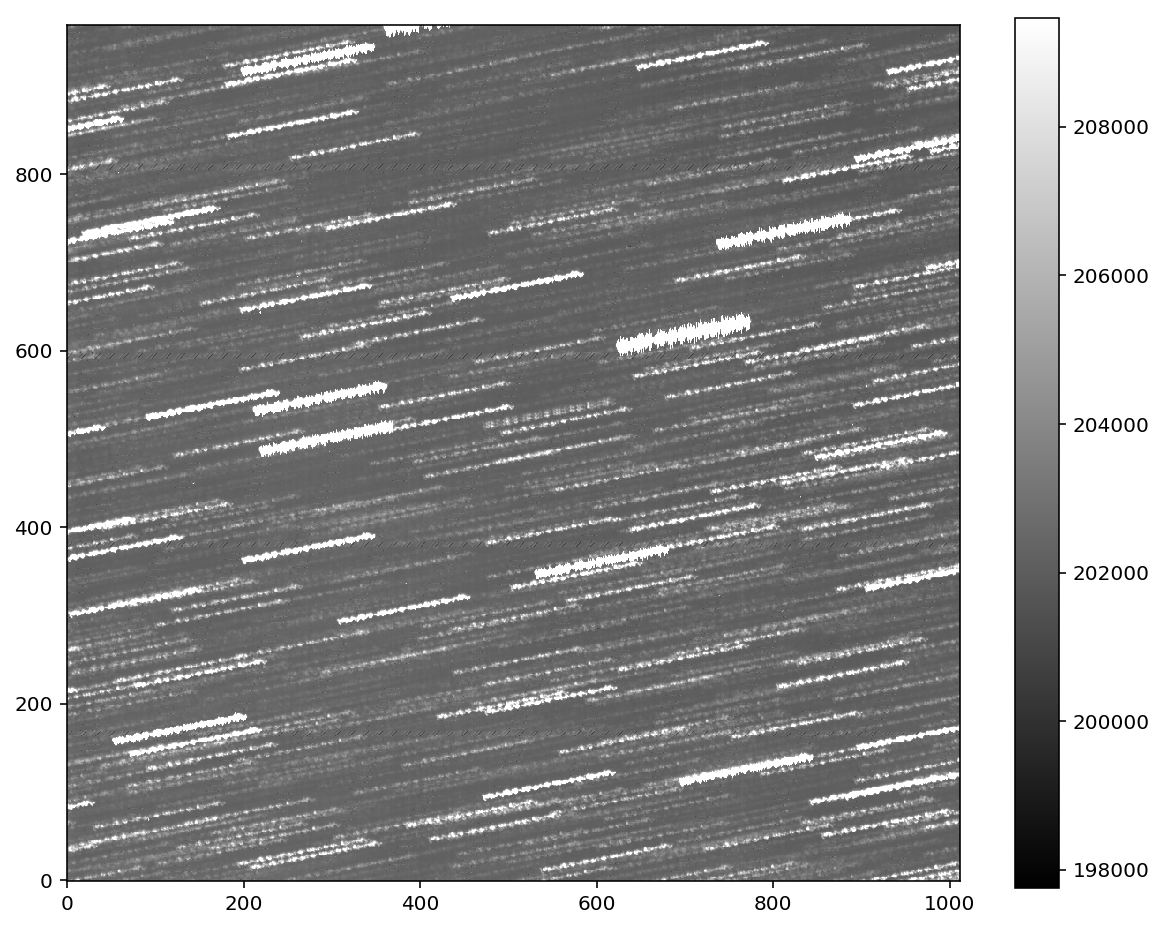

In [7]:
ffi_tools.quick_plot(data)

Background subtract

In [8]:
data_sub, bkg = ffi_tools.background_subtract(data, return_bkg=True)

## Object detection

Now that we've subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we're setting the detection threshold to be a constant value of $1.5 \sigma$ where $\sigma$ is the global background RMS.

In [9]:
kernel = ffi_tools.get_kernel()

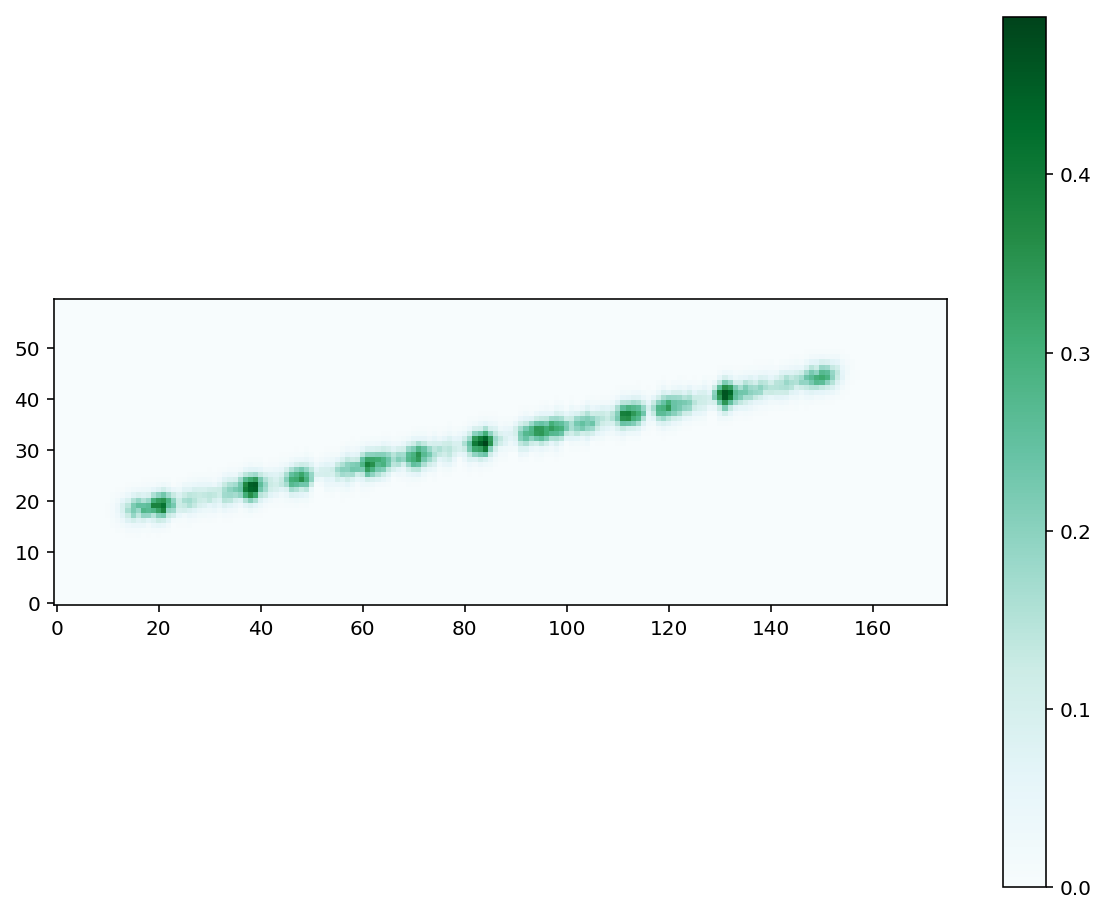

In [10]:
ffi_tools.plot_kernel(kernel)

### Source extraction with the kernel.

In [11]:
objects = sep.extract(data_sub, 4.0, filter_kernel=kernel,  err=bkg.globalrms)

In [12]:
df_objects = pd.DataFrame(objects)

In [13]:
df_objects.shape # N_objects x n_columns

(140, 30)

In [14]:
#df_objects.iloc[0]

`objects['x']` and `objects['y']` will give the centroid coordinates of the objects.

We know that some objects exhibit poor fits.  Let's filter the objects based on their metadata.
- Rotation angles should be close to 10 degrees.
- The semi-minor axes should be small; large semi-minor axes are indicative of saturated stars.

In [15]:
#plt.hist(objects['theta']* 180. / np.pi, bins=np.arange(0, 30, 1));
#plt.hist(objects['b'], bins=np.arange(0, 30, 1));

In [16]:
ny, nx = kernel.shape

In [17]:
poor_fits = ( ((objects['theta']* 180. / np.pi) > 20) |
              (objects['b'] > 15.0) |
              (objects['x'] < (nx/2 + 2)) | 
              (objects['x'] > ( sx - nx/2 - 2)) |
              (objects['y'] < (ny/2 + 2)) |  
              (objects['y'] > ( sy - ny/2 - 2)) )

In [18]:
saturated_mask = (objects['b'] > 5.0) & ~poor_fits

In [19]:
from matplotlib.patches import Rectangle

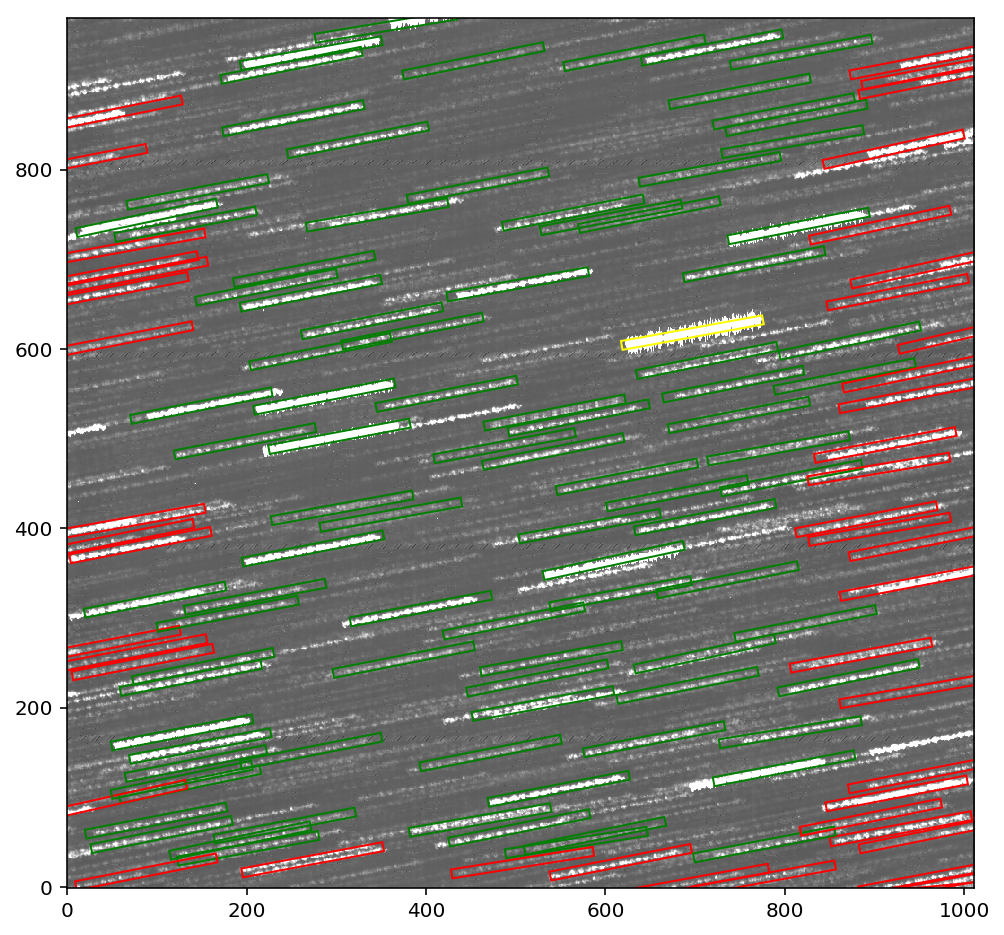

In [20]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    if poor_fits[i]:
        color = 'red'
    elif saturated_mask[i]:
        color = 'yellow'
    else:
        color = 'green'
    e = Rectangle(xy=(objects['x'][i]-80, objects['y'][i]-18),
                width=160,
                height=10,
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor(color)
    ax.add_artist(e)

### Make lightcurves for all objects!

First, make a custom aperture mask.

In [21]:
aper_mask = ffi_tools.get_aperture_mask(kernel, 3)

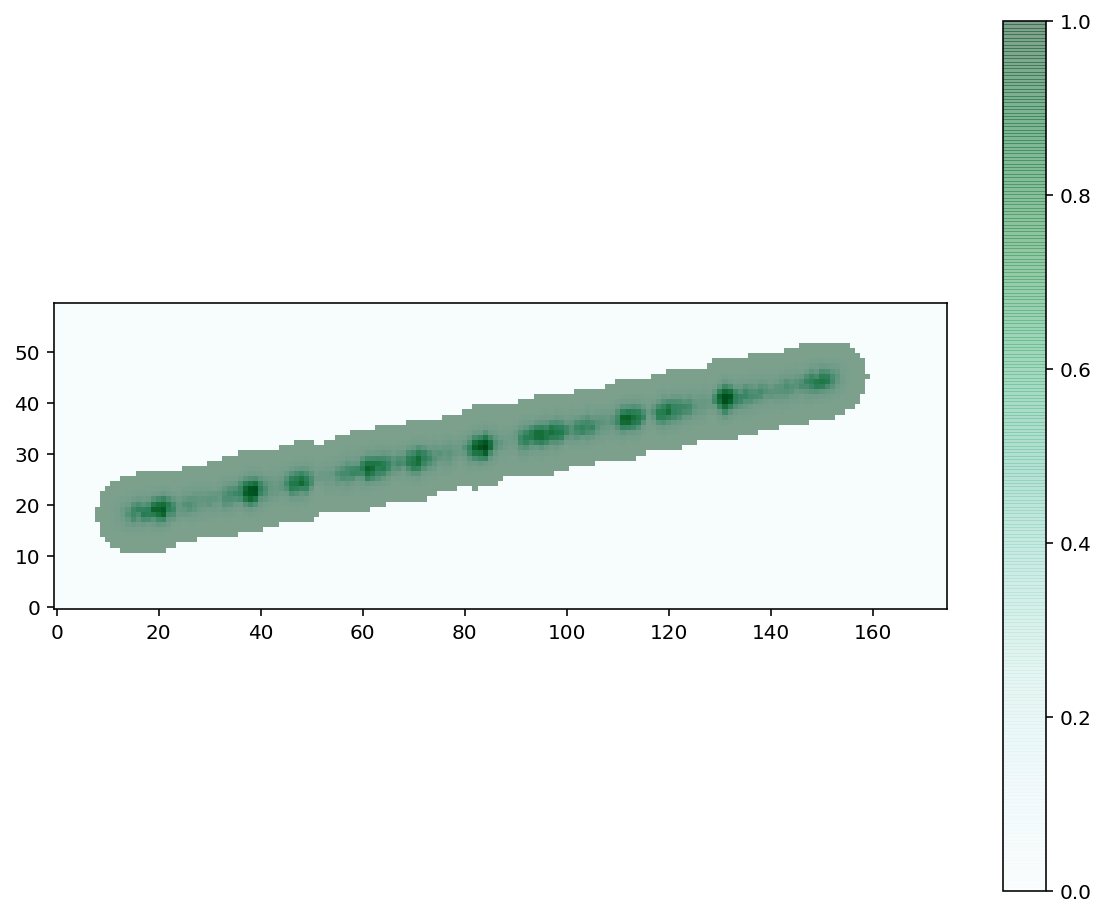

In [22]:
ffi_tools.plot_kernel(kernel, aper_mask=aper_mask)

In [23]:
faint_df = df_objects[~poor_fits & ~saturated_mask]

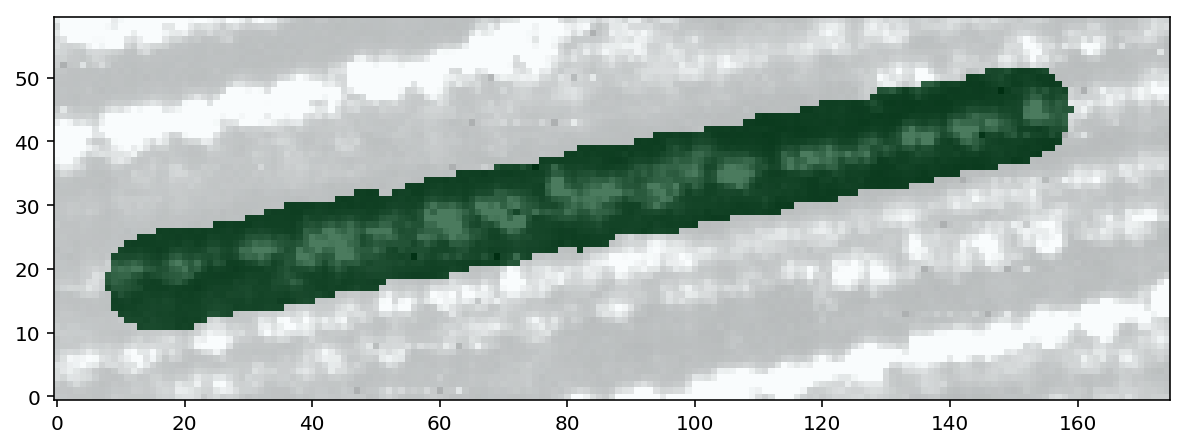

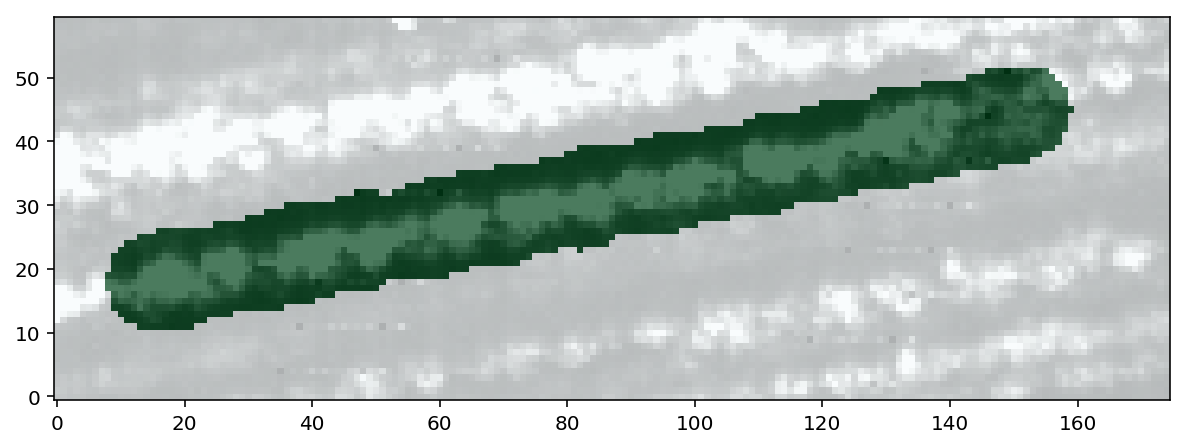

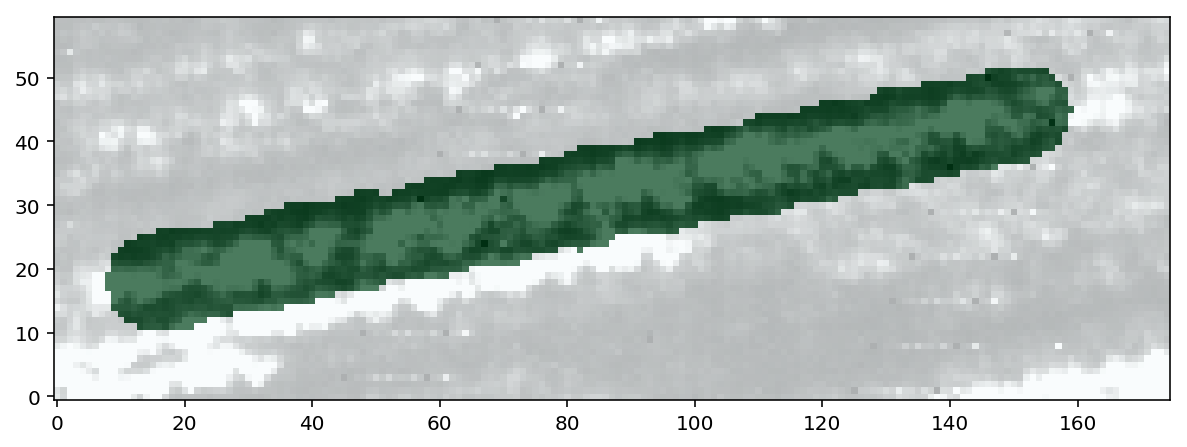

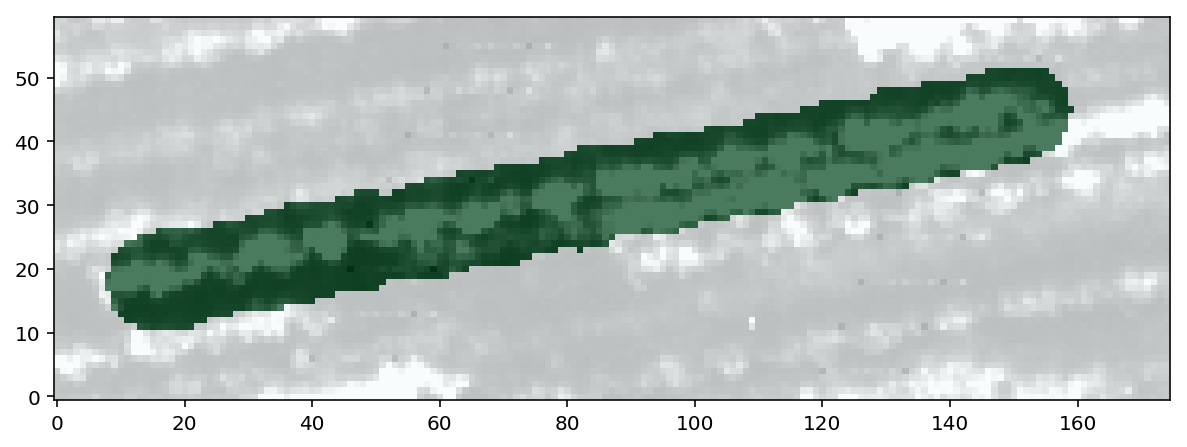

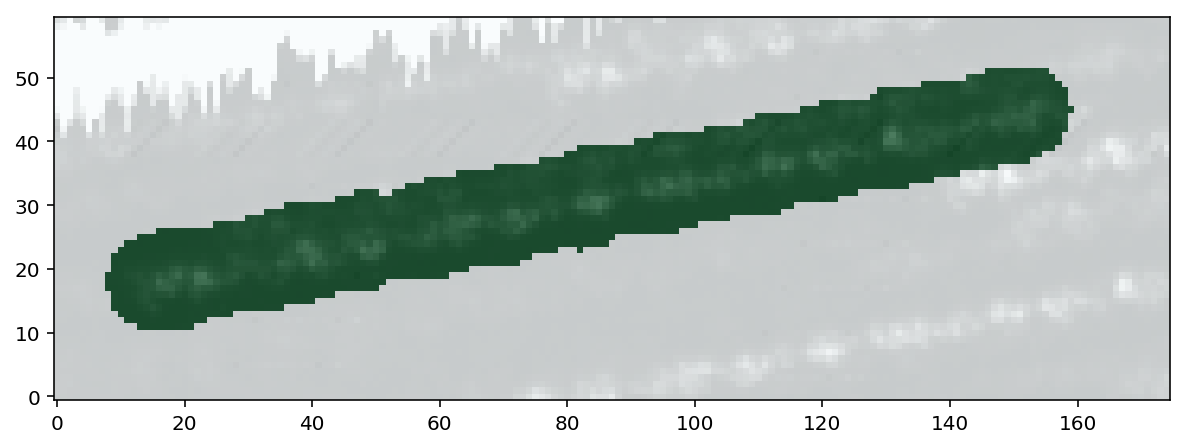

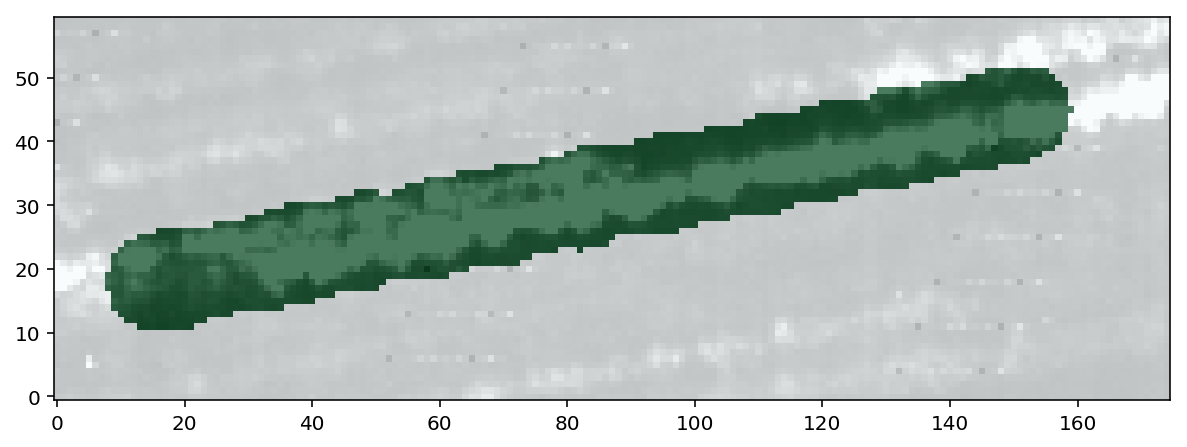

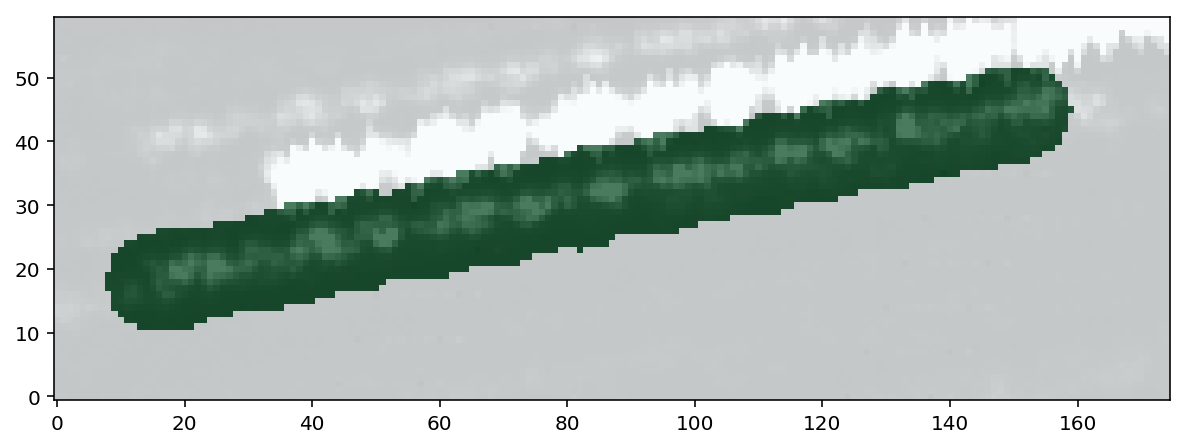

In [24]:
traces, flags = ffi_tools.iterate_line_traces(data_sub, faint_df.x.values, faint_df.y.values, aper_mask, 
                                              show_every_n_plots=15)

Clean the failed ones.

In [25]:
faint_df = faint_df[flags].reset_index(drop=True)
traces = traces[flags]

Hmmm... It looks like we have minute shifts in the $x$ position.  We also see that the highest signal to noise sources have common structures (as we anticipated from the visual inspection of the lightcurves).  We can refine the coarse $x$ position by picking a high-signal-to-noise-ratio template and cross-correlating it with each other lightcurve to determine a $\delta_x$.

In [26]:
faint_df['coarse_mean'], faint_df['coarse_std'] = traces.mean(axis=1), traces.std(axis=1)

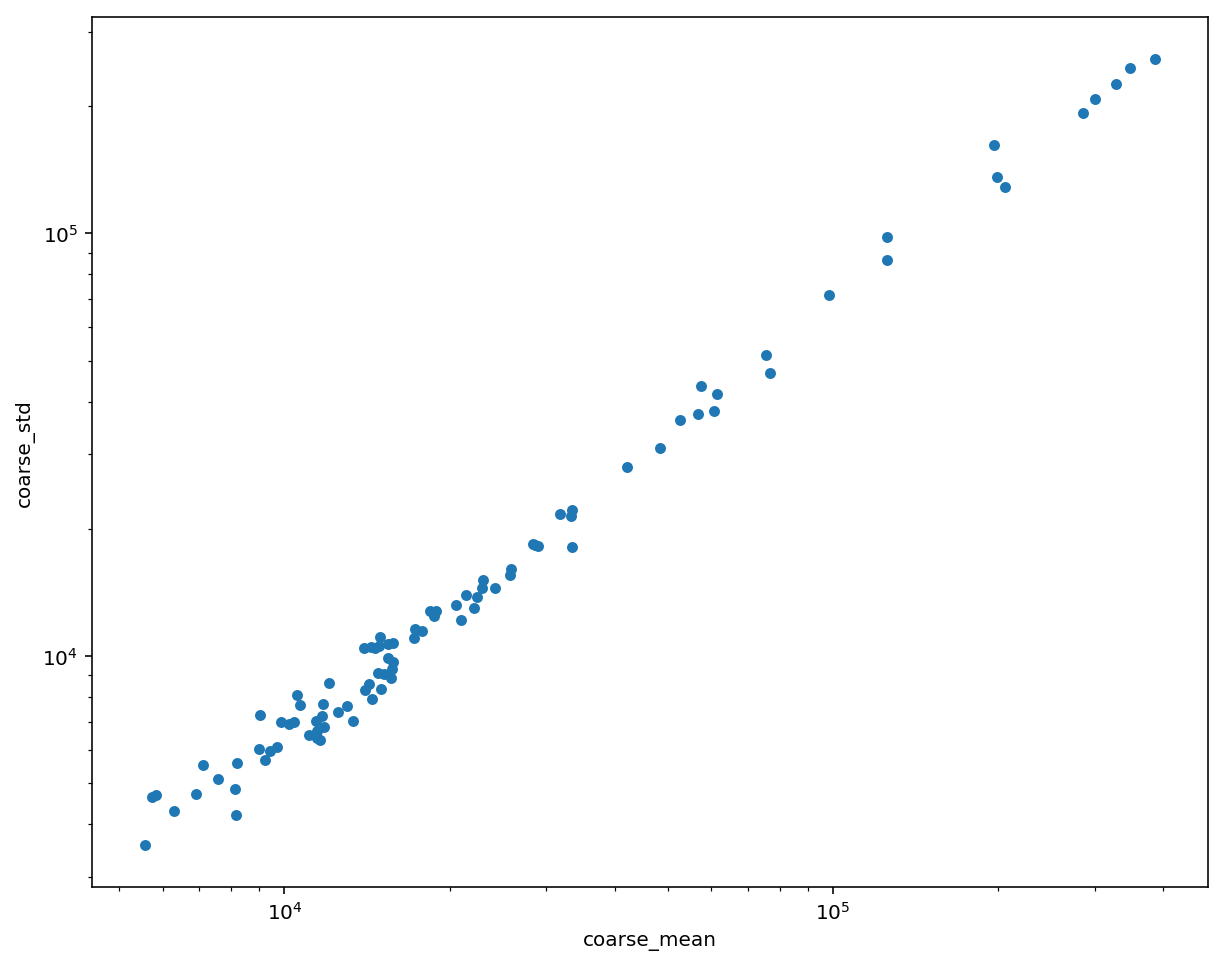

In [27]:
faint_df.plot('coarse_mean', 'coarse_std', kind='scatter', logx=True, logy=True)

It seeems like the spacecraft motion dominates the variance across a wide swath of source intensities.  We'll pick the source with the largest mean.

Not lined up!

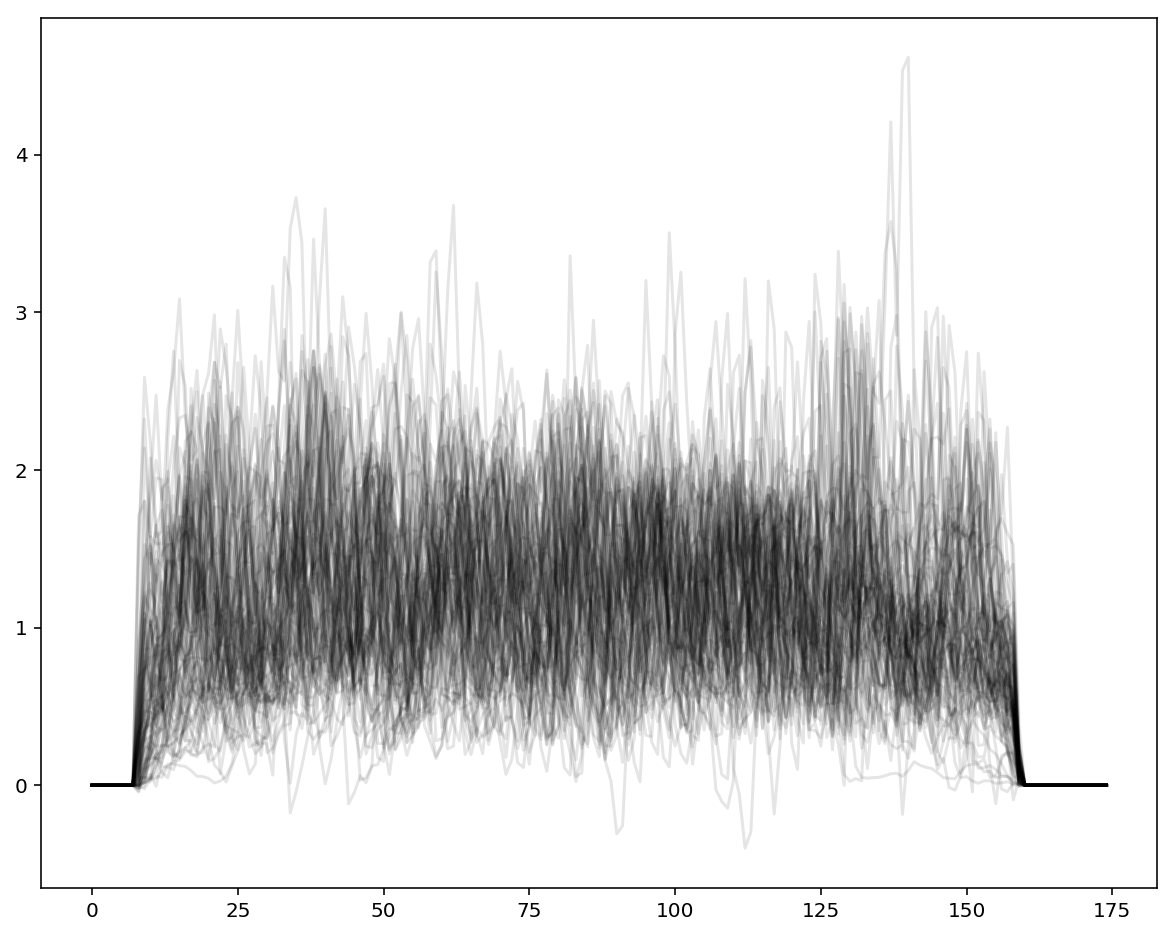

In [28]:
plt.plot(traces.T / faint_df.coarse_mean.values, 'k-',alpha=0.1);

The signals are not lined up enough, we need to cross-correlate and register them to the correct times.  
We'll use a high signal-to-noise ratio traces.

In [29]:
template_id = faint_df.coarse_mean.idxmax()
template_trace = traces[template_id, :]

In [30]:
traces.shape

(92, 175)

In [31]:
delta_xs = ffi_tools.get_delta_x_offsets(traces, template_trace)

In [32]:
faint_df['delta_x'] = np.array(delta_xs)

In [33]:
x_vec = np.arange(0, nx)

We need to convert pixel position (x) to time in minutes.

In [34]:
minutes_per_pixel = 29.4 /152.0

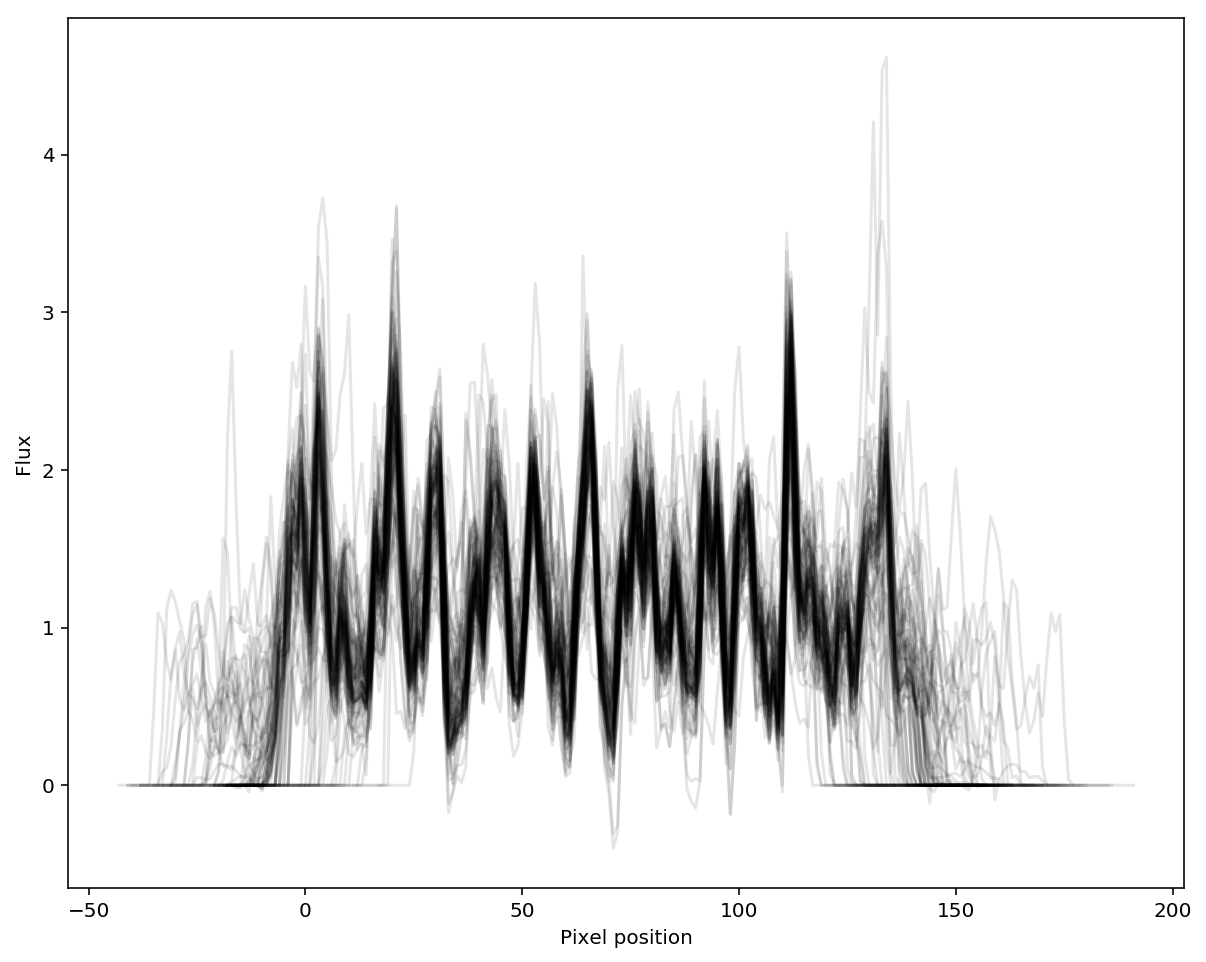

In [35]:
#for i in range(n_faint):
rank = 0
for i in range(len(faint_df)):
    corrected_x = x_vec + faint_df.delta_x[i] - 14
    time_vec = corrected_x #* minutes_per_pixel
    if True:#faint_df.coarse_mean[i] > 40000:
        plt.plot(time_vec, traces[i,:]/faint_df.coarse_mean[i] + 0, 'k-', alpha=0.1);
    rank += 1
    
plt.xlabel('Pixel position')
plt.ylabel('Flux');

Not bad!  But what if we go back and revise everything with the correct x, y positions in the first place?

In [36]:
dy_dx = np.arctan(faint_df.theta)

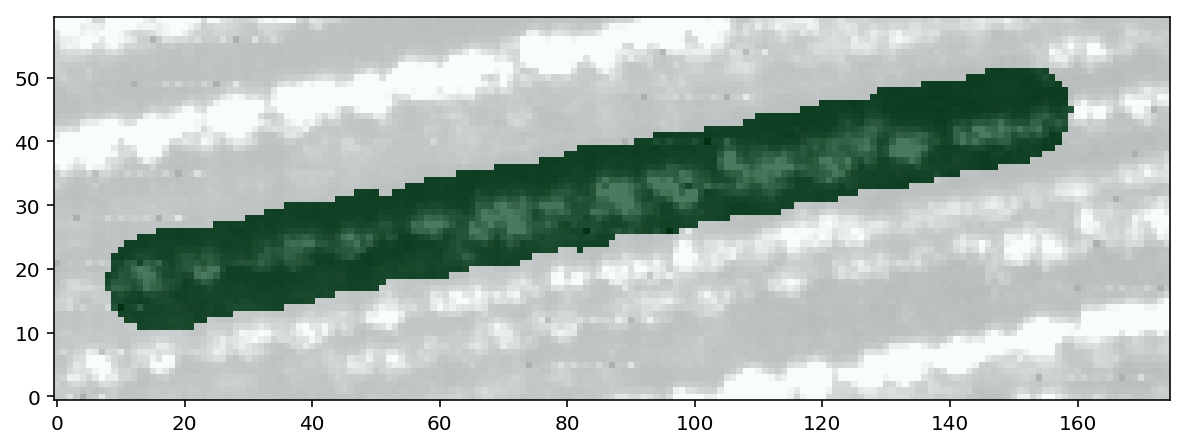

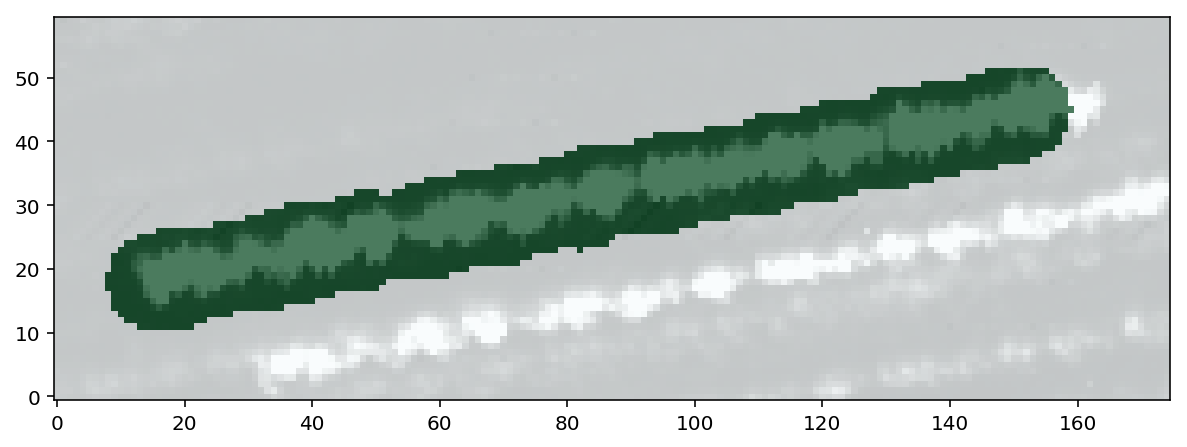

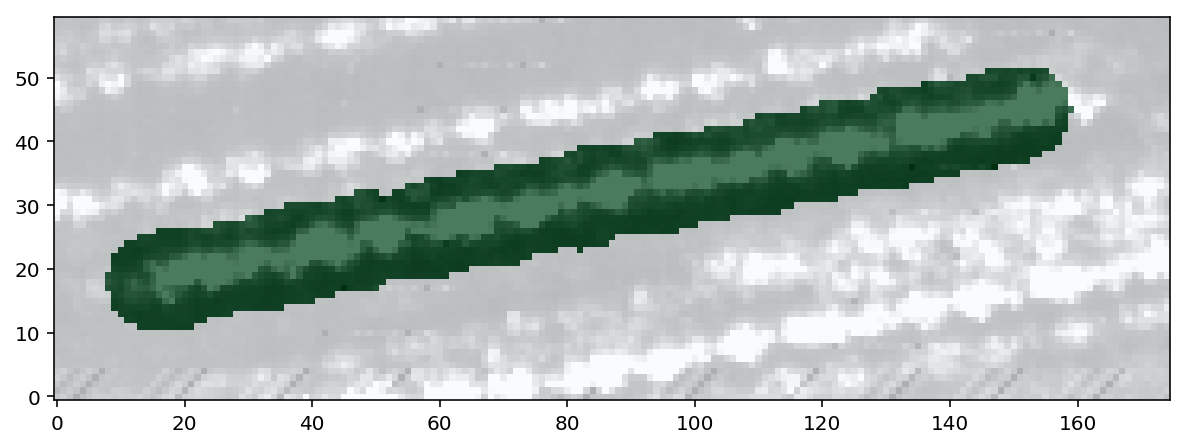

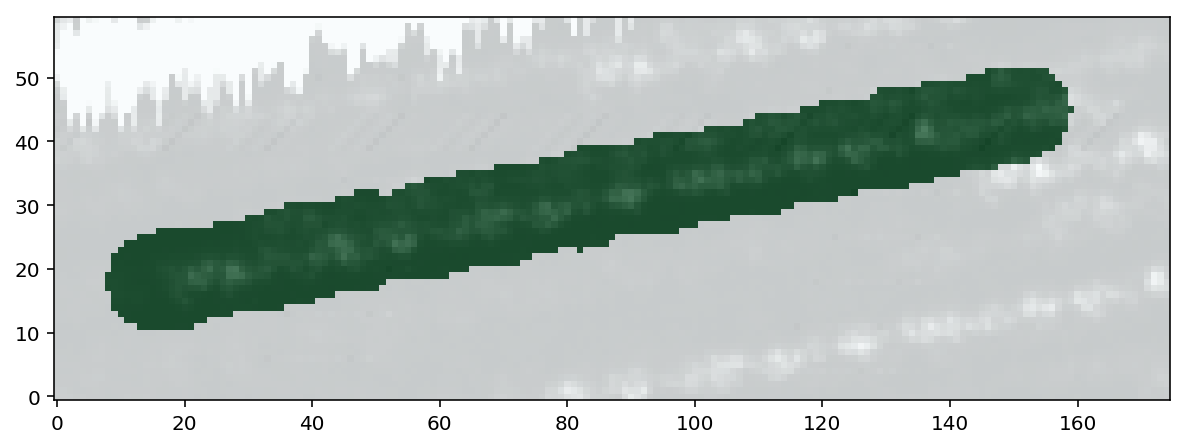

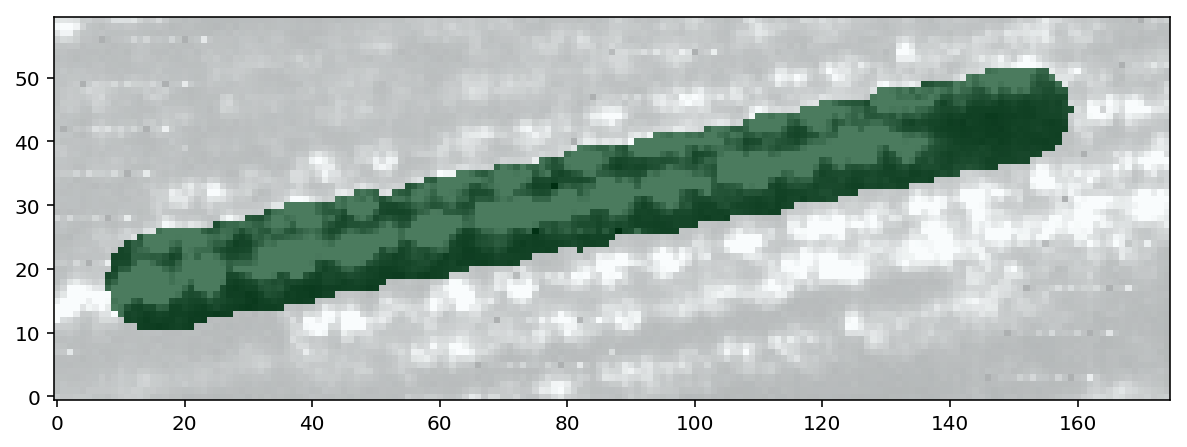

In [37]:
traces, flags = ffi_tools.iterate_line_traces(data_sub, faint_df.x.values+faint_df.delta_x, 
                                              faint_df.y.values+ faint_df.delta_x*dy_dx, 
                                              aper_mask, 
                                              show_every_n_plots=20)

/Users/obsidian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


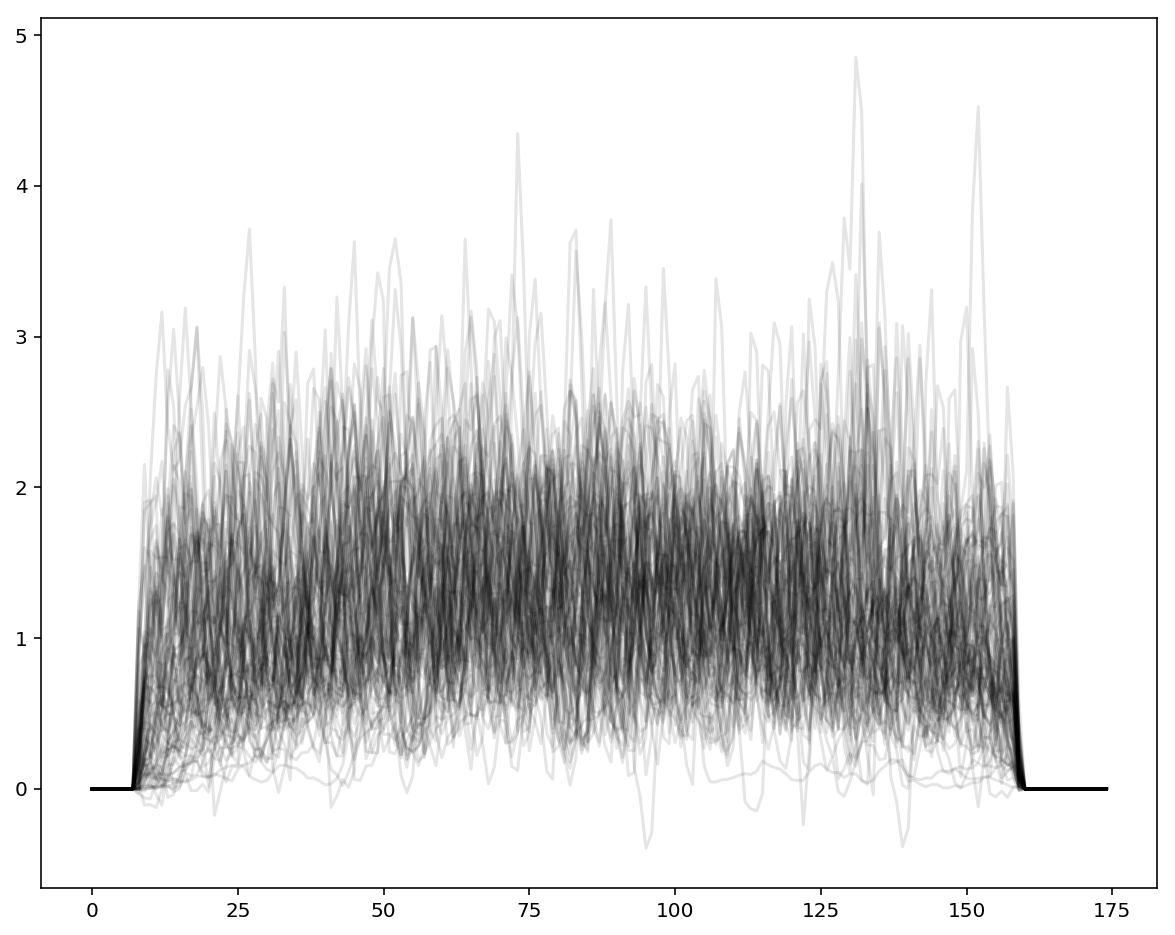

In [38]:
plt.plot(traces.T / traces.T.mean(axis=0), 'k-',alpha=0.1);

Meh, not that much better...

In [39]:
dwell_time = 1.0/template_trace
dwell_time = dwell_time / np.median(dwell_time)

/Users/obsidian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [40]:
dwell = dwell_time[9:157]
dwell = dwell / np.sum(dwell) # normalize
dwell = dwell * (29.4 * 60.0)

(0, 60)

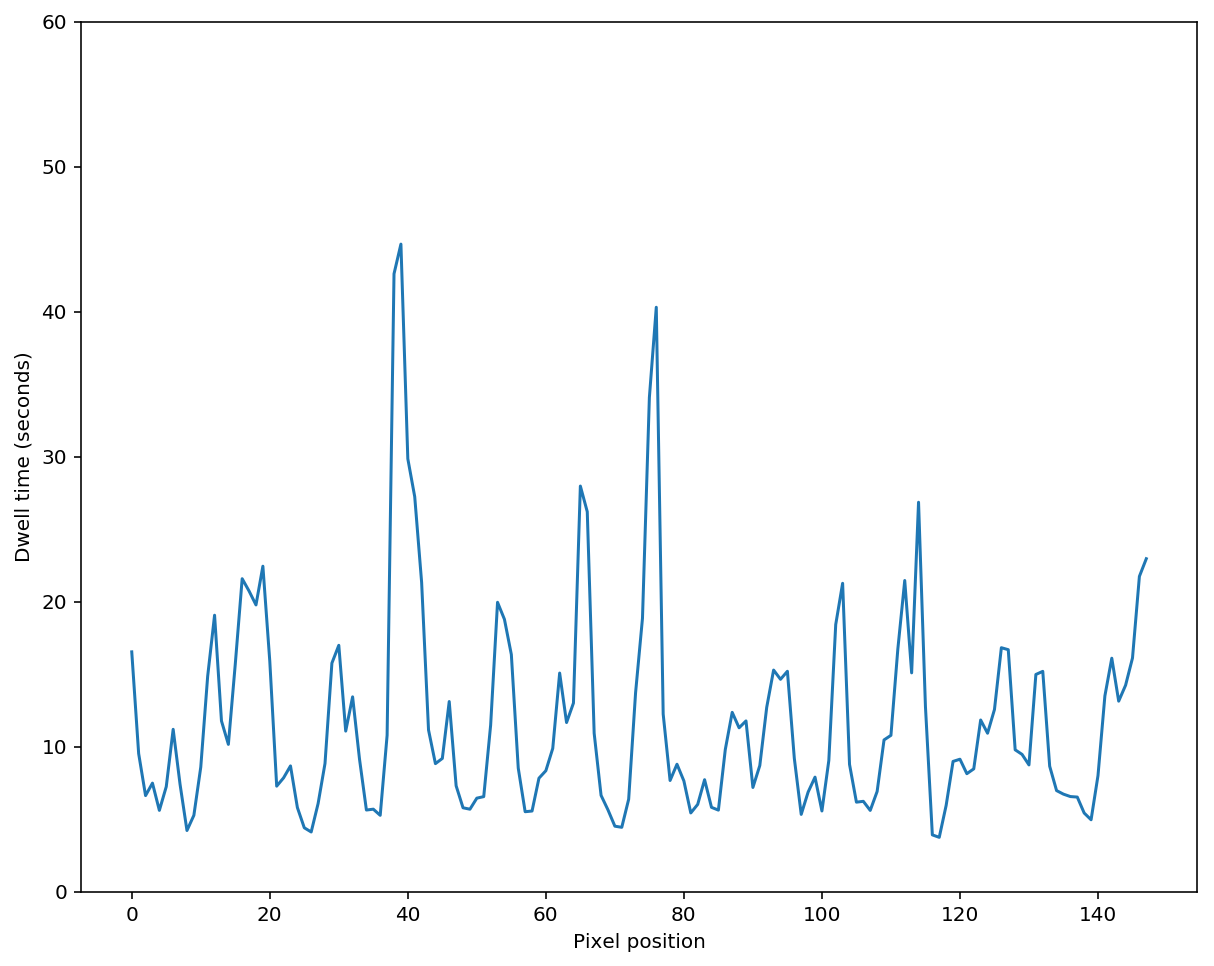

In [41]:
plt.plot(dwell)
plt.ylabel('Dwell time (seconds)')
plt.xlabel('Pixel position')
plt.ylim(0, 60)

Save the dwell time per pixel for use in simulations.

In [42]:
dwell

array([16.5384566 ,  9.52284663,  6.6229882 ,  7.48235965,  5.60322781,
        7.23963441, 11.19518365,  7.39562332,  4.21449814,  5.261538  ,
        8.58880547, 14.85581205, 19.06683868, 11.77197202, 10.15533725,
       15.69585744, 21.5844198 , 20.73254986, 19.77635597, 22.4478581 ,
       15.89509972,  7.27577163,  7.84780842,  8.67021957,  5.79559613,
        4.40195803,  4.11331331,  6.0724521 ,  8.83729092, 15.76217924,
       16.98999936, 11.07186401, 13.43572605,  9.13942963,  5.62679769,
        5.68614917,  5.2616867 , 10.78496351, 42.61615304, 44.66658399,
       29.85662489, 27.24303331, 21.33404736, 11.15126268,  8.82719676,
        9.18604086, 13.11177048,  7.29805674,  5.78233328,  5.68408173,
        6.44624732,  6.55182682, 11.4838968 , 19.95751637, 18.78172528,
       16.35343402,  8.51996839,  5.51097934,  5.55816098,  7.82325554,
        8.33950484,  9.87916267, 15.07651141, 11.66243194, 13.00791767,
       27.97675652, 26.20458264, 10.92220393,  6.63894054,  5.63

In [43]:
time_vector = np.cumsum(dwell)

$\theta(t) = \theta_0 + \omega  t + \frac{1}{2} \frac{d \omega}{d t}  t^2$

In [44]:
speed = 4.0 / dwell

In [45]:
import seaborn as sns

In [46]:
sns.set_context('talk')

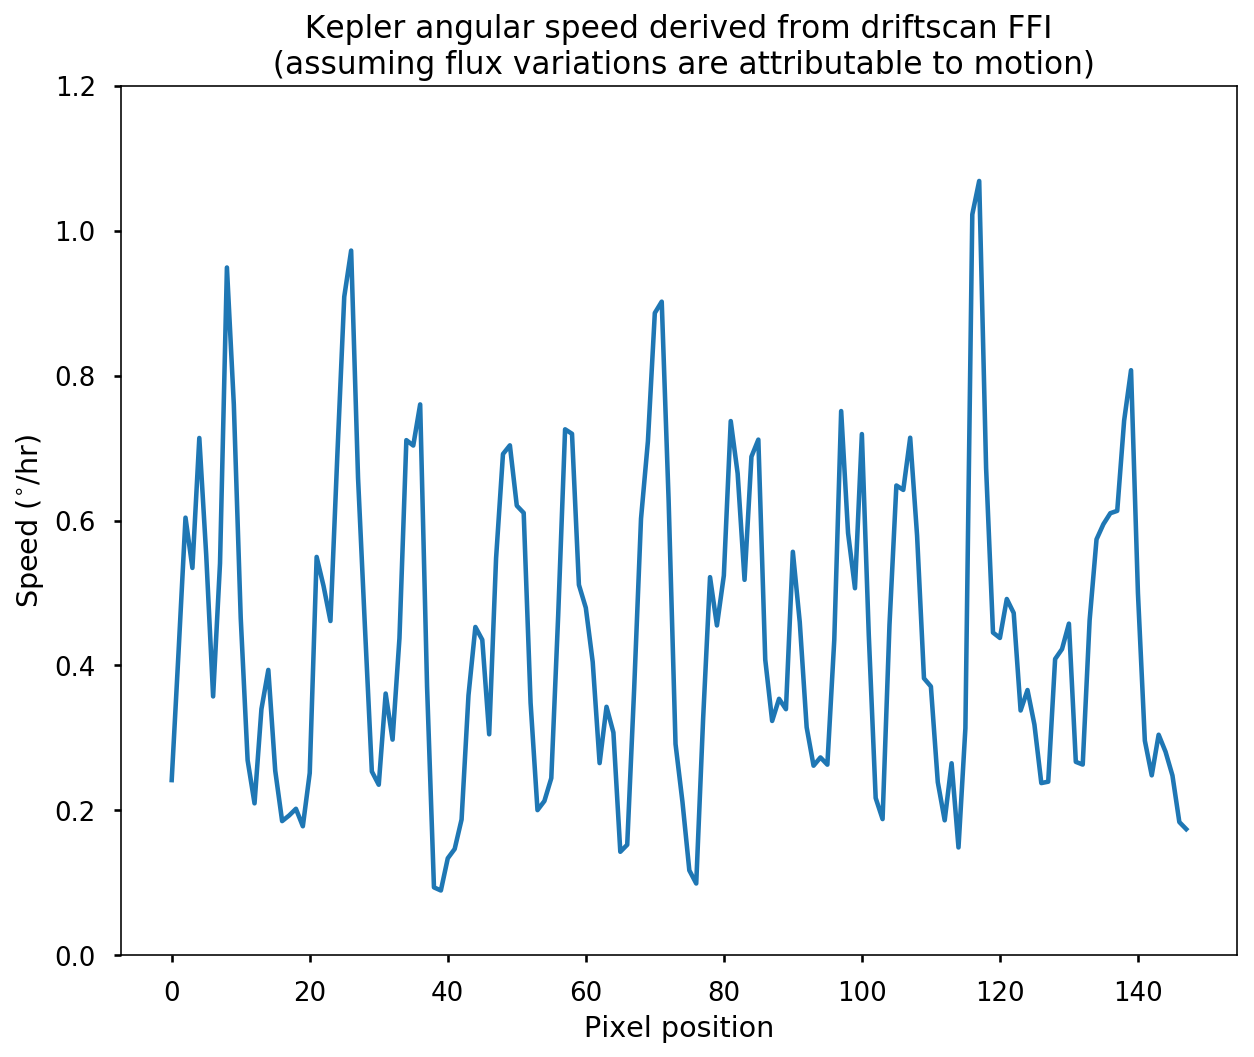

In [47]:
plt.plot(speed)
plt.ylabel('Speed ($^{\circ}$/hr)')
plt.xlabel('Pixel position')
plt.ylim(0, 1.2)
plt.title(' Kepler angular speed derived from driftscan FFI \n (assuming flux variations are attributable to motion)');

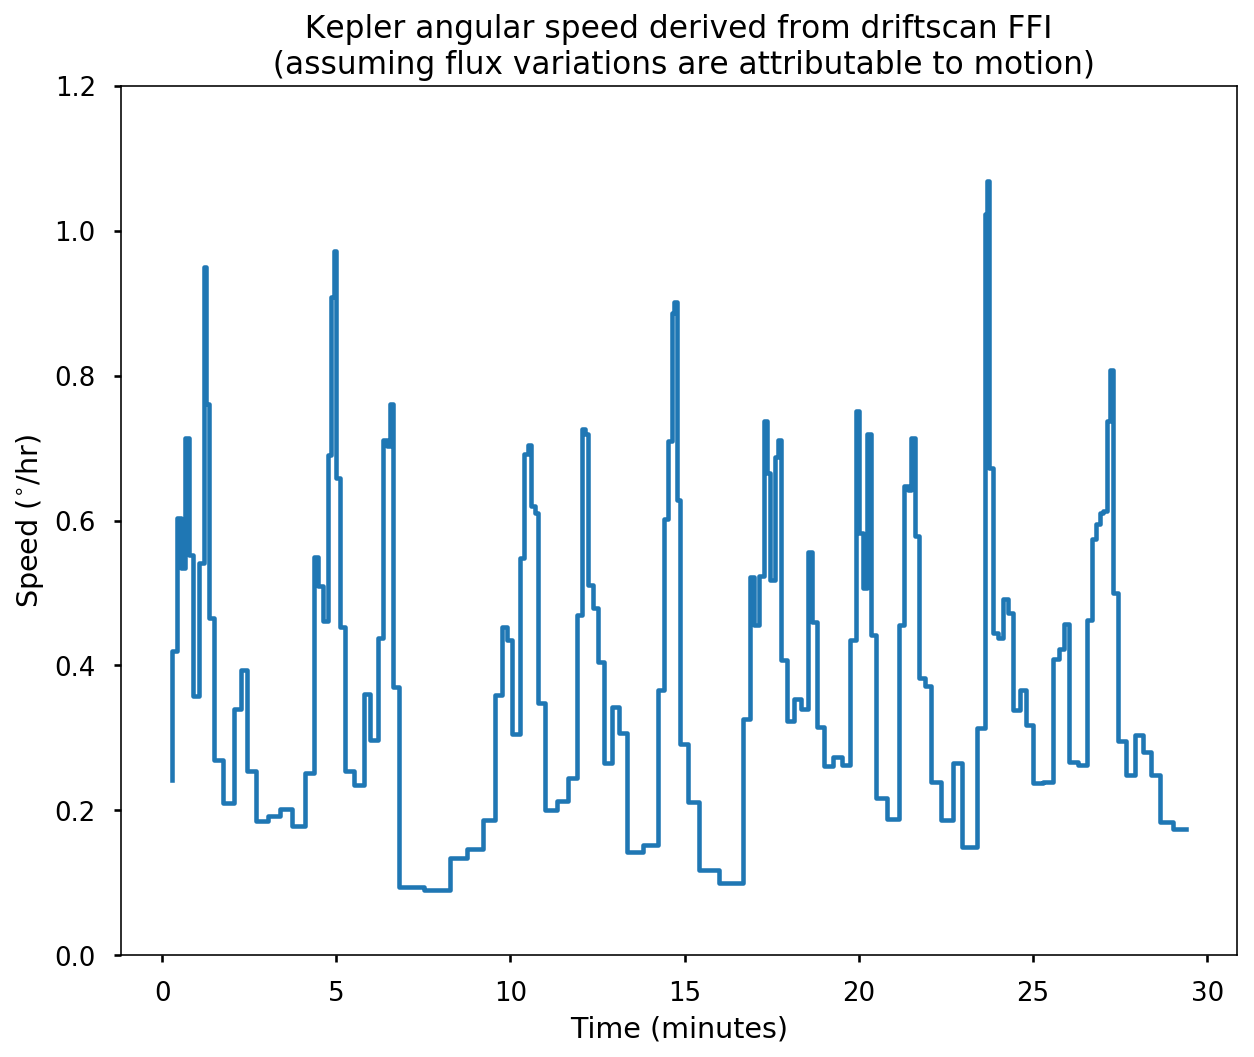

In [48]:
plt.step(time_vector/60.0, speed)
plt.ylabel('Speed ($^{\circ}$/hr)')
plt.xlabel('Time (minutes)')
plt.ylim(0, 1.2)
plt.title(' Kepler angular speed derived from driftscan FFI \n (assuming flux variations are attributable to motion)');
plt.savefig('../figures/driftscan_speed_v_time.png', dpi=300, bbox_inches='tight')

In [49]:
! open ../figures/